### Questions: 

 - How to "validate" that our model and our hyperparameters are a good fit to the data ? 
 - What to do when model underperforms ?
 


In [7]:
## MODEL VALIDATION: Wrong way to 'validate' the model

# 0. Get dataset
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

# 1. Choose model, fit data, predict label
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X, y)
y_model = model.predict(X) # WRONG DO NOT MAKE PREDICTION ON DATA USED FOR TRAINING !!

# 2. Get model accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

In [8]:
## MODEL VALIDATION: Right way, use Holdout sets

# Holdout sets : Hold back some subset of the data from the training of the model,
#                and then use thid holdout set to check the model performance

# 0. Split the data into training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0,
                                                    train_size = 0.5 # 50/50 split between training and test sets
                                                   )

# 1. Fit the model & Evaluate it
model.fit(X_train, y_train)
y_model = model.predict(X_test)
accuracy_score(y_model, y_test)

# Problem: We have lost 50% of the data for training -> Cross-validation

/Users/nicolas/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.9066666666666666

### Cross-validation: 
- Do a sequence of fits where each subset of the data is used both as a training set and as a validation set

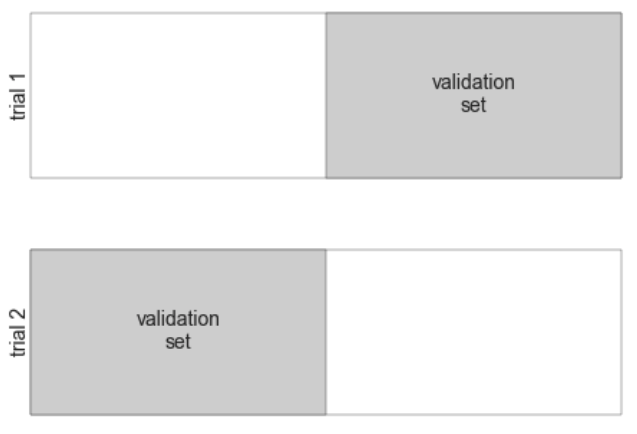


In [37]:
# 1. Fit the model & Evaluate it twice (two-fold cross validation)

y_model_1 = model.fit(X_train, y_train).predict(X_test)
y_model_2 = model.fit(X_test, y_test).predict(X_train)

print("1st model accuracy: ", accuracy_score(y_model_1, y_test))
print("2nd model accuracy: ", accuracy_score(y_model_2, y_train))

# Then, take the mean of the output to get an average 93% accuracy.
# You can expand on this ieda to use even more trails

# 5-fold cross validation
from sklearn.model_selection import cross_val_score
print("Accuracy 5-Fold: ", cross_val_score(model, X, y,
                                           cv=5 # number of folds
                                          ).mean())

# Leave-one out cross validation (Train on all the datapoints except one -> nb_sample models = 150 models)
from sklearn.model_selection import LeaveOneOut
LeaveOneOut()
scores = cross_val_score(model, X, y,
                         cv=LeaveOneOut())
print("Accurary Leave-one out: ", scores.mean())

1st model accuracy:  0.9066666666666666
2nd model accuracy:  0.96
Accuracy 5-Fold:  0.96
Accurary Leave-one out:  0.96


In [18]:
## SELECTION THE BEST MODEL

# What to do if the model behave poorly? 
- Use a more/less complicated model
- Gather more training examples (+ samples)
- Gather more data to add features to each sample(+ features)


### Bias-variable trade-off

- Choosing the "best" model is about finding the middle ground between 'bias' and 'variance'
- 'High Bias' = Underfits the data
    - Detection: Performance on validation set similar to performance of training set
    - Solutions: More complex/flexible model
- 'High Variance' = Overfits the data (Reflect the noise properties of the data)
    - Detection: Performance on validation set far worse than performance of training set
    - Solution: Less complex/flexible model

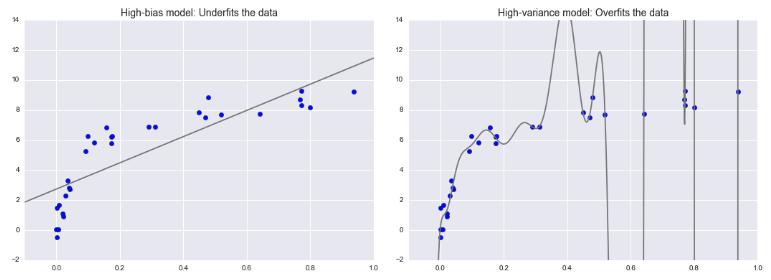




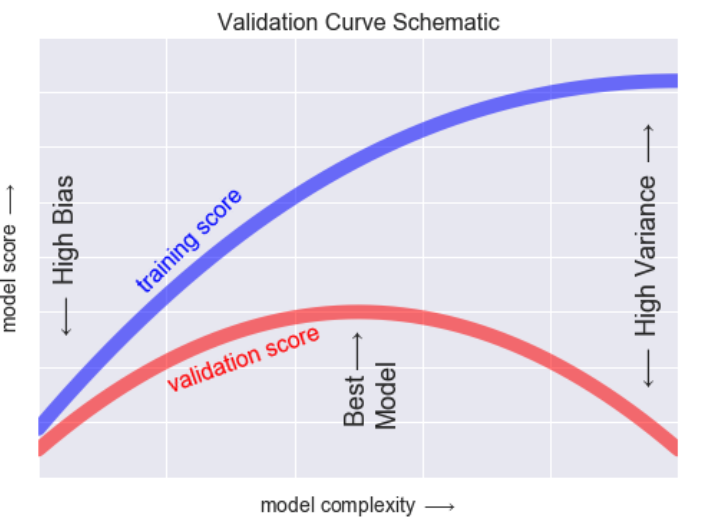

In [2]:
# Polynomial regression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import numpy as np

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), # Get a feature matr. consisting of all poly. comb. of the features
                         LinearRegression(**kwargs))

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1)**2 # Random values in the shape (N, 1)
    y = 10 - 1.0/(X.ravel() + 0.1)
    if err > 0:
        y += err*rng.randn(N) # Add noise to target
    return X, y

X, y = make_data(40)
# X is (40, 1)
# y is (40,)

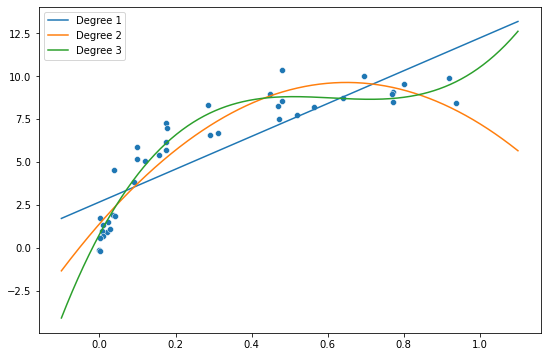

In [3]:
# Visualize the data
import matplotlib.pyplot as plt
import seaborn as sns

X_test = np.linspace(-0.1, 1.1, 500)[:, np.newaxis] # X_test is (500, 1)

# Plot the training set
fig, axes = plt.subplots(figsize = (9, 6))

sns.scatterplot(x = X.ravel(),
                y = y.ravel(),
                ax=axes)

# Plot the different poly regression

for degree in [1, 2, 3]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    sns.lineplot(x = X_test.ravel(),
                 y = y_test.ravel(),
                 ax = axes,
                 label = f"Degree {degree}")
    
# What degree of polynomial provides the best trade-off between biais and variance ?
    

/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Score')

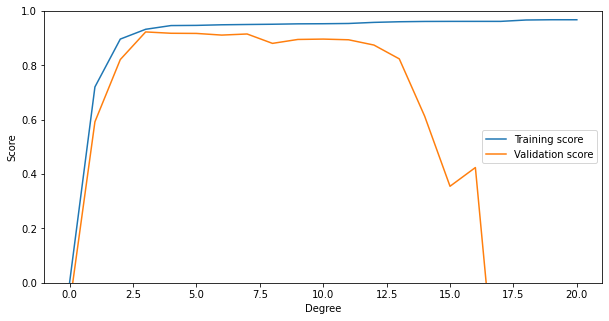

In [4]:
# Visualize validation curve

from sklearn.model_selection import validation_curve

degree = np.arange(0, 21) # List the degree to test, here from 0 to 21
train_score, validation_score = validation_curve(PolynomialRegression(), # Model to test (only 1 param: degree)
                                                 X, y,
                                                 'polynomialfeatures__degree', # Name of the param. that will be varied,
                                                 degree, # values of the parameter that will be evaluated
                                                 cv = 7 # 7-Fold cross-validation
                                                )

# About 'polynomialfeatures__degree' -> PolynomialRegression().get_params() to get the list of all params
# trains_score shape is (21, 7) 
# validation_score shape is (21, 7) 

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(degree, np.median(train_score, 1), label='Training score', ax = ax)
sns.lineplot(degree, np.median(validation_score, 1), label='Validation score', ax=ax)
ax.set_ylim(0, 1);
ax.set_xlabel("Degree")
ax.set_ylabel("Score")

<AxesSubplot:>

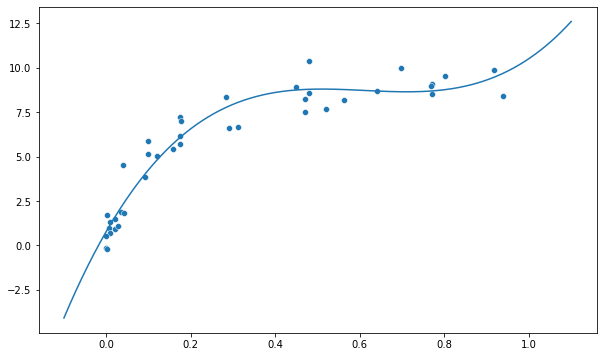

In [5]:
# Vizualize the best model (degree = 3)

# Fit the model with degree = 3
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)

fig, axes = plt.subplots(figsize=(10, 6))
sns.scatterplot(x = X.ravel(),
            y = y.ravel(),
            ax = axes)
sns.lineplot(x = X_test.ravel(),
            y = y_test.ravel(),
            ax = axes)


X2 shape : (200, 1) // y2 shape: (200,)


(0.0, 1.0)

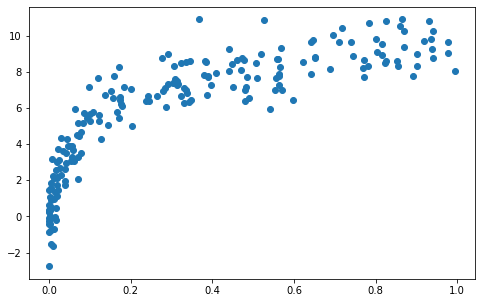

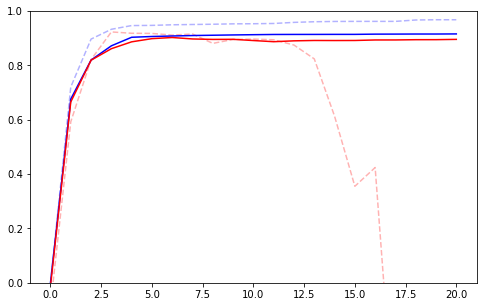

In [6]:
# Learning Curve

# Optimal model depend on the size of the training data

X2, y2 = make_data(200)
print(f"X2 shape : {X2.shape} // y2 shape: {y2.shape}")

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X2.ravel(), y2)

degree = np.arange(0, 21) # List the degree to test, here from 0 to 21
train_score_2, validation_score_2 = validation_curve(PolynomialRegression(), # Model to test (only 1 param: degree)
                                                 X2, y2,
                                                 'polynomialfeatures__degree', # Name of the param. that will be varied,
                                                 degree, # values of the parameter that will be evaluated
                                                 cv = 7 # 7-Fold cross-validation
                                                )

fig, ax = plt.subplots(figsize=(8, 5))
# Validation curve with original data
sns.lineplot(x = degree.ravel(),
             y = np.median(train_score, axis=1).ravel(),
             ax=ax,
             color = 'blue',
             alpha = 0.3,
             linestyle = '--')
sns.lineplot(x = degree.ravel(),
             y = np.median(validation_score, axis=1).ravel(),
             ax=ax,
             color = 'red',
             alpha = 0.3,
             linestyle = '--')
# Validation curve with bigger data
sns.lineplot(x = degree.ravel(),
             y = np.median(train_score_2, axis=1).ravel(),
             ax=ax,
             color = 'blue')
sns.lineplot(x = degree.ravel(),
             y = np.median(validation_score_2, axis=1).ravel(),
             ax=ax,
             color = 'red')
ax.set_ylim(0, 1)

In [114]:
np.median(train_score, axis=1)

array([0.        , 0.72060505, 0.8966661 , 0.93273606, 0.94641559,
       0.94706837, 0.94928043, 0.95034312, 0.95126473, 0.9527462 ,
       0.95316414, 0.95410179, 0.95812976, 0.9604493 , 0.96155007,
       0.9618062 , 0.96182215, 0.96184623, 0.96687065, 0.9678403 ,
       0.96779042])

# Learning curve

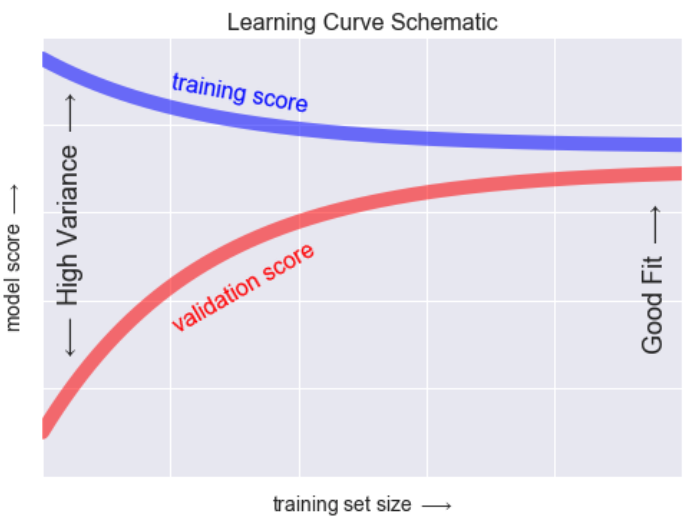

- Once you have enough points that a particular model has converged, adding more training data will NOT help

In [23]:
ax[0]

TypeError: 'AxesSubplot' object does not support indexing

/Users/nicolas/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/nicolas/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator


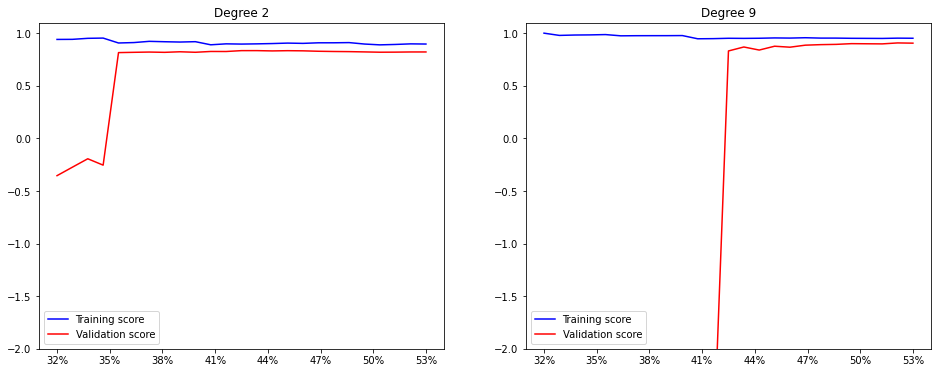

In [47]:
# Visualize learning curve
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Get learning curve for 2 different model:
for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv = 7,
                                         train_sizes=np.linspace(0.3, 1, 25), # Relative value of the training set
                                         )
    # N = Number of training example that has been used to generate the learning curve = 25
    # train_lc = Average training score for each training set. Shape = (25, 7)
    # train_lc = Average validation score for each validation set. Shape = (25, 7)
    
    sns.lineplot(x = 100*np.linspace(0.3, 1, 25),
                 y = np.median(train_lc, axis = 1),
                 color = 'blue',
                 ax = ax[i],
                 label = "Training score")
    sns.lineplot(x = 100*np.linspace(0.3, 1, 25),
                 y = np.median(val_lc, axis = 1),
                 color = 'red',
                 ax = ax[i],
                 label = "Validation score")
    ax[i].set_ylim(-2, 1.1)
    ax[i].set_xticklabels([str(int(e)) + "%" for e in 100*np.linspace(0.3, 1, 25)])
    ax[i].set_title(f"Degree {degree}")

Best params for our data:  {'linearregression__fit_intercept': False, 'linearregression__normalize': True, 'polynomialfeatures__degree': 4}


/Users/nicolas/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

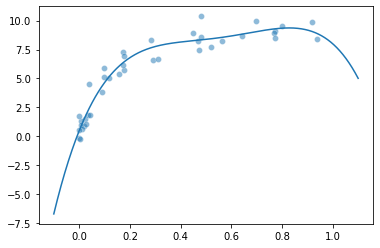

In [61]:
# Grid search

# In general, models have more that 1 knob to turn(not only the number of degree in poly regression)
# -> Validation + Learning curve change from lines to multidimentional surfaces -> Hard to vizualize
# --> Simply find the particular model that maximizes the validation score

from sklearn.model_selection import GridSearchCV

# Define the parameter to play with
params_grid = {"polynomialfeatures__degree": np.arange(21),
               "linearregression__fit_intercept": [True, False],
               "linearregression__normalize": [True, False]}

grid = GridSearchCV(PolynomialRegression(), # Model to test
                    params_grid, # Combination of model paramter to test
                    cv = 7
                    )

# Fit the grid to data
grid.fit(X, y) # Size of training set is fixed -> Play with model complexity only

# Ask for the best paramters
print("Best params for our data: ", grid.best_params_)

# Plot the best polynomial curve according to the GridSearch
# Get the best model from the grid
model = grid.best_estimator_

y_model = model.fit(X, y).predict(X_test)

fig, ax = plt.subplots()
sns.scatterplot(X.ravel(), y,
                ax = ax,
                alpha = 0.5)
sns.lineplot(X_test.ravel(), y_model,
                ax = ax,
                alpha = 1)


### Concept summary

- Holdout Set: Hold back some subset of the data from the training of the model to check for the model performance
- Cross-Validation: Sequence of fits where each subset of the data is used both as training set and validation set.
    - Example: 2-fold cross-validation, Leave one out
- Bias-Variace trade-off:
    - bias: Underfit the data
        - Solution: More complex model / More features
    - variance: Overfit the data
        - Solution: Simpler model / More data

-  R square: Measure quality of regression prediction. R = 1 --> Perfect model

    - $R^2 = 1-\dfrac{\sum_{i=1}^n\left(y_i-\hat{y_i}\right)^2}{\sum_{i=1}^n\left(y_i-\bar y\right)^2}$

    - $y_i$ = Valeur de la mesure numero $i$
    - $\hat{y_i}$ = Valeur prédite de la mesure numero $i$
    - $\bar y$ = Valeur moyenne des mesures
    - $R^2$ Vizualisation:

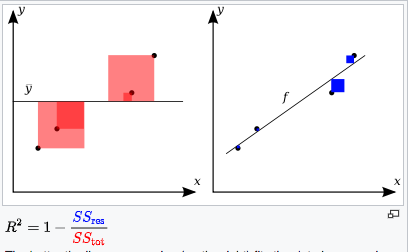

- Validation curve: Plot of the training/validation score with respect to the model complexity
- Learning curve: Plot of the training/validation score with respect to the size of the training set
- Grid Search: To overcome the multidimensinal issue with validation and learning curves. For a given training/test set, find the best model parameter